# <center> Preprocess </center>
<center> Josh Wilkins <br> 10/13/2017 </center>

In [1]:
# Imports

import pandas as pd
import numpy as np
import seaborn as sbn
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Collect Some Data (Extra Song Info Grabbed in IRSC Section)

df_train = pd.read_csv('Data/train.csv')
df_test = pd.read_csv('Data/test.csv')
df_songs = pd.read_csv('Data/songs.csv')
df_members = pd.read_csv('Data/members.csv')
df_logs = pd.read_csv('Data/user_logs.csv')

### <center> IRSC Data </center>

Notes:
- Info is not verified (could be misleading or incorrect)
- Multiple songs can share the same IRSC if song is re-published
- IRSC split into CC-XXX-YY-NNNNN
    - CC is Country Code
    - XXX is IRSC Issuer (Record Label Company)
    - YY is the year the IRSC was assigned (not necessarily the year it was recorded)
    - NNNNN is just a 5 digit id number
- yy is changed to yyyy (Split at 18 so data is from 1918 to 2017)

In [3]:
# Spliting IRSC Data into CC-XXX-YY (Removed Name and IRSC Cols)

df_songs_extra = pd.read_csv('Data/song_extra_info.csv')
print "%.2f percent of IRSCs are duplicates" % (100 - float(100*len(df_songs_extra.isrc.unique())) / float(len(df_songs_extra.isrc)))
print "%.2f percent of IRSCs are missing" % (100 * float(df_songs_extra.isrc.isnull().sum()) / float(len(df_songs_extra.song_id)))

x = pd.Series(df_songs_extra.isrc.values)
df_songs_extra['cc'] = x.str.slice(0,2)
df_songs_extra['xxx'] = x.str.slice(2,5)
df_songs_extra['yy'] = x.str.slice(5,7).astype(float)
del df_songs_extra['isrc']

df_songs_extra['yy'] = df_songs_extra['yy'].astype(float)
df_songs_extra.loc[df_songs_extra['yy'] > 17, 'yy'] += 1900
df_songs_extra.loc[df_songs_extra['yy'] < 18, 'yy'] += 2000
df_songs_extra.rename(columns={'yy': 'yyyy'}, inplace=True)

df_songs_extra.head()

21.30 percent of IRSCs are duplicates
5.95 percent of IRSCs are missing


,song_id,name,cc,xxx,yyyy
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TW,UM7,2012.0
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QM,ZSY,2016.0
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TW,A53,2008.0
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,US,SM1,2013.0
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TW,A47,2013.0


### <center> Membership Length </center>

Notes:
- Created new col days = exp_date - reg_time
- Removed exp_date and reg_time (Data encapsulated in days)
    - As Jian Yang points out in the comments here: https://www.kaggle.com/juanumusic/days-instead-of-dates-lgbm-0-66870 <br>
      Days and reg_time are highly correlated since the exp_dates are very similar

In [4]:
# Creating new Feature Column: days = mebership length

# Date-time objects for date manipulation
df_members['registration_init_time'] = pd.to_datetime(df_members['registration_init_time'],format="%Y%m%d")
df_members['expiration_date'] = pd.to_datetime(df_members['expiration_date'],format="%Y%m%d")

# Creating the new feature column
df_members['days'] = (df_members.expiration_date - df_members.registration_init_time).dt.days.astype(int)

# Removing reg_time and exp_data feature cols
del df_members['registration_init_time']
del df_members['expiration_date']

### <center> Adding Features: Count by Seperations (|) in Data </center>

These include:
- Lyricist
- Genre Ids
- Composer

In [5]:
# Adding Counts of | Separarted Fields
cols = ['genre_ids', 'lyricist', 'composer']
for col in cols:
    tmp_array = []
    df_songs[col] = df_songs[col].fillna('NA')
    for row in df_songs[col]:
        tmp_array.append(len(row.split('|')))
    df_songs[col + '_count'] = tmp_array

### <center> Removing Features </center>

Reasons for removing gender column:
- Over 40% of the data is missing
- Data shows that user is not more likely to repeat song if male or female

57.85% of gender data missing


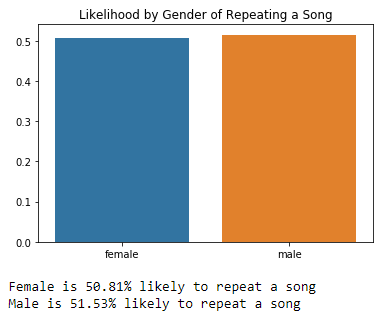

In [6]:
# Gender Data
missingGenderData = 100 * float(df_members.gender.isnull().sum()) / len(df_members.msno)
print "%.2f%% of gender data missing" % missingGenderData

Image(filename='./Images/Target_By_Gender.png', width=400) 

Lyricist data removed because 43% of its data is missing (48% missing in test data) <br>
Song_name removed because it contains the same content as song_id
- Although if using public data song name might become useful

In [7]:
# Removig Features

del df_logs['date']
del df_logs['num_75']
del df_logs['num_unq']
del df_members['gender']
del df_members['registered_via']
del df_songs['lyricist']
del df_songs_extra['name']

### <center> User Logs </center>

In [8]:
# Summing User Log Data

counts = df_logs.groupby('msno')['total_secs'].count().reset_index()
counts.columns = ['msno', 'days_listened']
sums = df_logs.groupby('msno').sum().reset_index()
del df_logs
df_logs = sums.merge(counts, how='inner', on='msno')

In [9]:
# Normalizing and Standardizing Data
from sklearn.preprocessing import StandardScaler

df_logs = df_logs[df_logs['total_secs'] >= 0]

cols = df_logs.columns.values[1:]
df_logs[cols] = np.log1p(df_logs[cols])

ss = StandardScaler()
df_logs[cols] = ss.fit_transform(df_logs[cols])

### <center> Removing Outliers </center>

Notes:
- Some Expiration_Dates in 1970 (Removed rows)
- Removed ages < 0 and > 95
    - Note about 40% of the ages == 0 -- why??
- Removed absurd song lengths (1 sec to 3 hrs)
    - 3hr ones due to 'meditative' songs (kept in data)
    - Short songs removed

In [13]:
# Removing Outliers

df_songs.language.dropna(inplace=True)  # Removing that one song without a language
    
# Replace Ages<=0 with the average age
# mean_age = df_members[df_members['bd'] > 0]['bd'].mean()
# df_members[df_members.bd <= 0] = np.round(mean_age)

df_members = df_members[df_members.days > 0] # Remove the 3 rows with 1970 exp_dates
# df_members = df_members[(df_members.bd > -1) & (df_members.bd < 95)]  # Remove the ages that don't make sense

df_songs = df_songs[df_songs['song_length'] > (30000)]

### <center> Merging Data </center>

Notes:
- 349 extra rows in the songs file
- 549 not common to both

In [14]:
# Merging Data: Songs with Song_Extra_Info

print str(np.shape(df_songs)) + " - Shape of songs.csv"
print str(np.shape(df_songs_extra)) + " - Shape of song_extra_info.csv"
songs = df_songs.merge(df_songs_extra, how='outer', on='song_id')
print str(np.shape(songs)) + " - Shape of merged files"

(2286890, 9) - Shape of songs.csv
(2295971, 4) - Shape of song_extra_info.csv
(2296862, 12) - Shape of merged files


By choosing the outer method, I am keeping the songs that are not common to both files

Notes:
- Every member is unique in members.csv
- Every member present in the concatenation of train and test
    - Not all members present in training data
    - Not all members present in test data
- The following merge adds member info to every member-song combo
- Also means that a small set of member info is not used in training set

In [15]:
# Merging members with user logs

df_members = df_members.merge(df_logs, how='right', on='msno')

### <center> Merging Training Data </center>

In [16]:
# Merging Training Set with Members Data

df = df_train.merge(df_members, how='left', on='msno')

Notes:
- The following merge adds song info to every member-song combo
- Not all songs present in training data
- Not all songs present in test data

In [17]:
# Merging Training Set with Song Data

train = df.merge(songs, how='left', on='song_id')

### <center> Merging Test Data </center>

In [18]:
# Merging Test Set with Members Data

df = df_test.merge(df_members, how='left', on='msno')

In [19]:
# Merging Test Set with Song Data

test = df.merge(songs, how='left', on='song_id')

### <center> Adding Features </center>

- Consider adding ratio of unique_listen_count / listen_count (Removes redundant data)

In [20]:
# Seperated Play Count
arr = train.song_id.value_counts()
pc = pd.DataFrame(data=[arr.index, arr.values]).T
pc.columns = ['song_id', 'play_count']
train = train.merge(pc, how='left', on='song_id')

arr = test.song_id.value_counts()
pc = pd.DataFrame(data=[arr.index, arr.values]).T
pc.columns = ['song_id', 'play_count']
test = test.merge(pc, how='left', on='song_id')

### <center> Formatted Data Frames to .csv Files </center>

In [21]:
# Formatted data to .csv
train.to_csv('Data/TrainFormatted.csv', index=False)
test.to_csv('Data/TestFormatted.csv', index=False)